In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('all_stocks_5yr.csv') 
print(data.shape) 
print(data.sample(7))

(619040, 7)
              date      open      high       low     close    volume  Name
564582  2016-07-22   32.3200   32.4300   32.0500   32.4100    963423   UNM
518880  2015-06-05  103.4300  103.9300  102.3900  103.8700   1023026   SRE
162267  2016-09-16   82.9300   83.3700   82.3900   83.2500   1142268   DGX
444154  2014-05-13   86.9500   87.4400   86.8100   87.2300   2259404   PEP
618561  2016-03-16   40.8600   40.8600   40.1000   40.4600   5147364   ZTS
408017  2015-01-23   60.9885   62.7428   60.8814   62.4935  26784352  NFLX
563663  2017-11-27  212.2500  214.2500  211.8100  212.4000   2856277   UNH


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [4]:
data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


ValueError: num must be an integer with 1 <= num <= 9, not 10

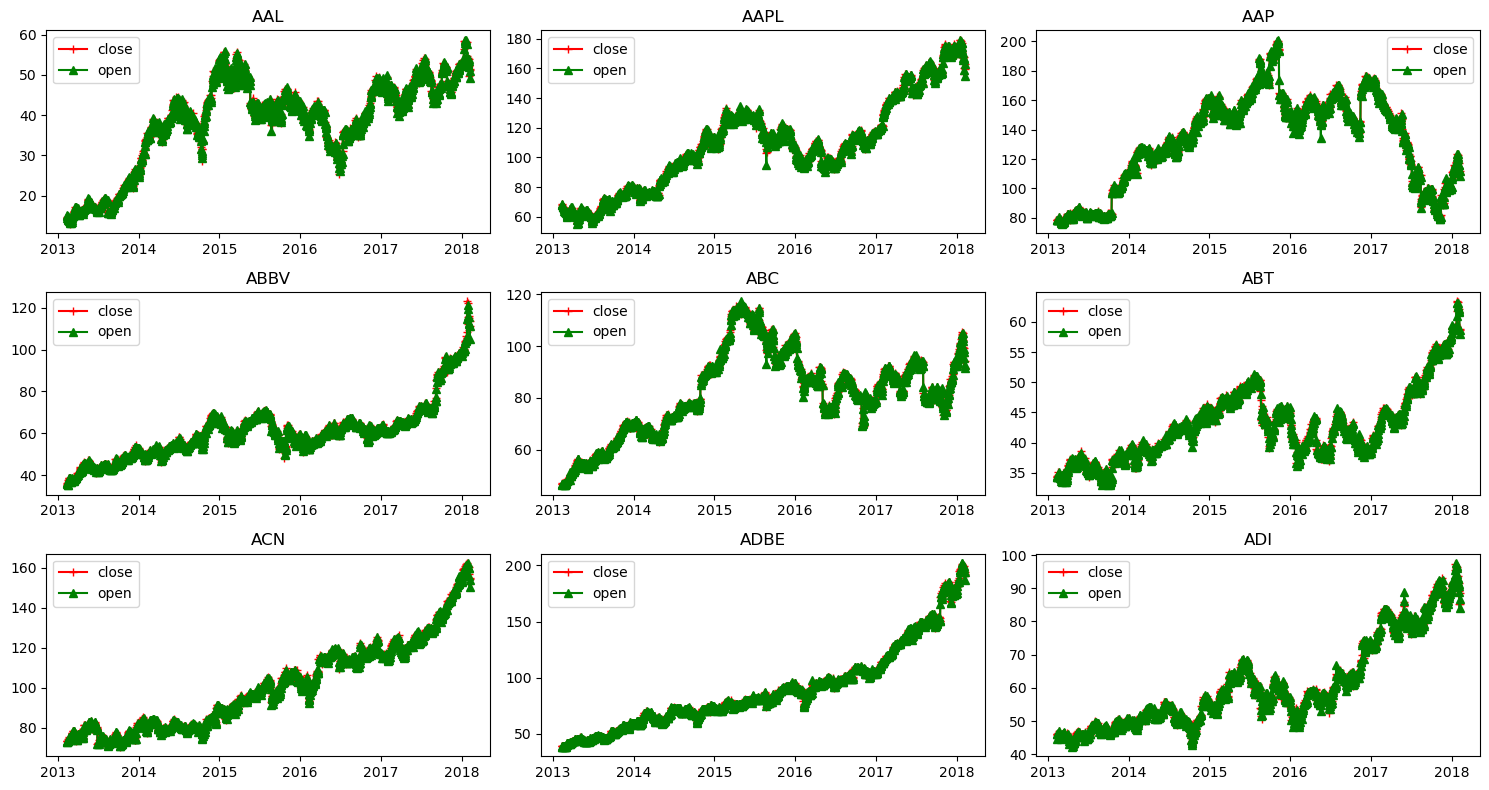

In [5]:

data['date']=pd.to_datetime(data['date'])
#date vs open
#date vs close
companies = data['Name'].unique()
plt.figure(figsize=(15,8))
for index, company in enumerate(companies, 1):
    plt.subplot(3,3,index)
    c=data[data['Name']==company]
    plt.plot(c['date'],c['close'],c="r",label="close",marker="+")
    plt.plot(c['date'],c['open'],c="g",label="open",marker="^")
    plt.title(company)
    plt.legend()
    
    plt.tight_layout()
    

In [ ]:
plt.figure(figsize=(15, 8)) 
for index, company in enumerate(companies, 1): 
    plt.subplot(3, 3, index) 
    c = data[data['Name'] == company] 
    plt.plot(c['date'], c['volume'], c='purple', marker='*') 
    plt.title(f"{company} Volume") 
    plt.tight_layout() 

In [ ]:
apple = data[data['Name'] == 'AAPL'] 
prediction_range = apple.loc[(apple['date'] > datetime(2013,1,1)) 
 & (apple['date']<datetime(2018,1,1))] 
plt.plot(apple['date'],apple['close']) 
plt.xlabel("Date") 
plt.ylabel("Close") 
plt.title("Apple Stock Prices") 
plt.show()

In [ ]:
close_data = apple.filter(['close']) 
dataset = close_data.values 
training = int(np.ceil(len(dataset) * .95)) 
print(training)

In [ ]:
from sklearn.preprocessing import MinMaxScaler 
  
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset) 
  
train_data = scaled_data[0:int(training), :] 
# prepare feature and labels 
x_train = [] 
y_train = [] 
  
for i in range(60, len(train_data)): 
    x_train.append(train_data[i-60:i, 0]) 
    y_train.append(train_data[i, 0]) 
  
x_train, y_train = np.array(x_train), np.array(y_train) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 

In [ ]:
model = keras.models.Sequential() 
model.add(keras.layers.LSTM(units=64, 
                            return_sequences=True, 
                            input_shape=(x_train.shape[1], 1))) 
model.add(keras.layers.LSTM(units=64)) 
model.add(keras.layers.Dense(32)) 
model.add(keras.layers.Dropout(0.5)) 
model.add(keras.layers.Dense(1)) 
model.summary 

In [ ]:
model.compile(optimizer='adam', 
              loss='mean_squared_error') 
history = model.fit(x_train, 
                    y_train, 
                    epochs=10) 

In [ ]:
test_data = scaled_data[training - 60:, :] 
x_test = [] 
y_test = dataset[training:, :] 
for i in range(60, len(test_data)): 
    x_test.append(test_data[i-60:i, 0]) 
  
x_test = np.array(x_test) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
  
# predict the testing data 
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) 
  
# evaluation metrics 
mse = np.mean(((predictions - y_test) ** 2)) 
print("MSE", mse) 
print("RMSE", np.sqrt(mse))

In [ ]:
train = apple[:training] 
test = apple[training:] 
test['Predictions'] = predictions 
  
plt.figure(figsize=(10, 8)) 
plt.plot(train['date'], train['close']) 
plt.plot(test['date'], test[['close', 'Predictions']]) 
plt.title('Apple Stock Close Price') 
plt.xlabel('Date') 
plt.ylabel("Close") 
plt.legend(['Train', 'Test', 'Predictions']) 